In [99]:
import numpy as np
import matplotlib.pyplot as plt
import microscopic_data_analysis as mda

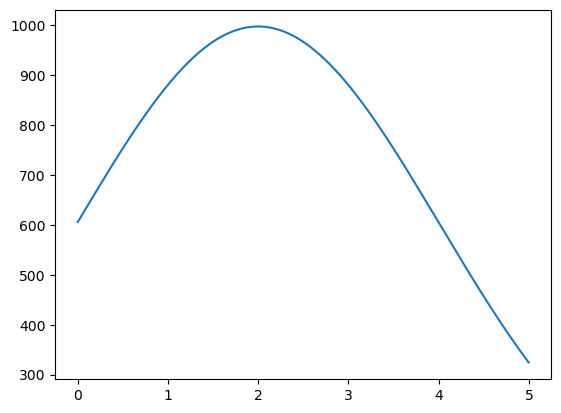

In [100]:
xbins=np.linspace(0,5,1001)
x=mda.bin_centering(xbins)

y=mda.Gaussian(x,x0=2,A=5000,sigma=2)
plt.plot(x,y)

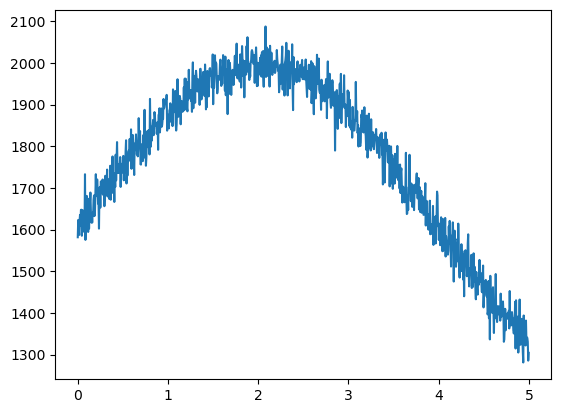

In [101]:
random_sample=np.random.uniform(0,5,size=10**6)
hist,bin_edges=np.histogram(random_sample,bins=xbins)
y+=hist
plt.plot(x,y)

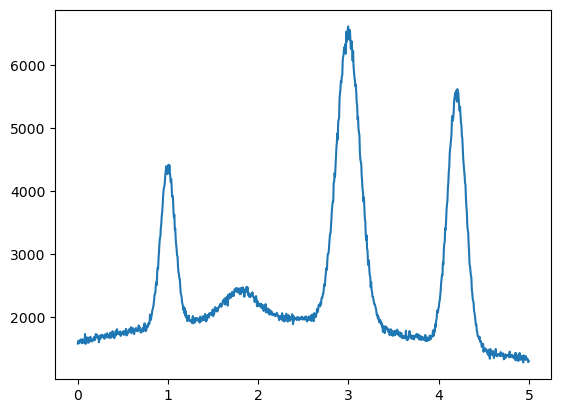

In [102]:
peak_positions=np.array([1,1.8,3,4.2])
peak_widths=np.array([0.08,0.18,0.13,0.1])
peak_intensities=np.array([10**5,4*10**4,3*10**5,2*10**5])

for i in range(4):
    random_sample=np.random.normal(peak_positions[i],peak_widths[i],peak_intensities[i])
    hist,bin_edges=np.histogram(random_sample,bins=xbins)
    y+=hist

plt.plot(x,y)

In [103]:
peak_intensity_factors=np.array([0.5,2,1,1])
cauchy_peak_intens=(peak_intensity_factors*peak_intensities).astype(int)
cauchy_peak_widths=peak_widths*np.array([2.4,1.2,3.6,1])
cauchy_pos=peak_positions+np.array([0.05,-0.1,0,0.05])

for i in range(4):
    random_sample=np.random.standard_cauchy(cauchy_peak_intens[i])*cauchy_peak_widths[i]+cauchy_pos[i]
    hist,bin_edges=np.histogram(random_sample,bins=xbins)
    y+=hist

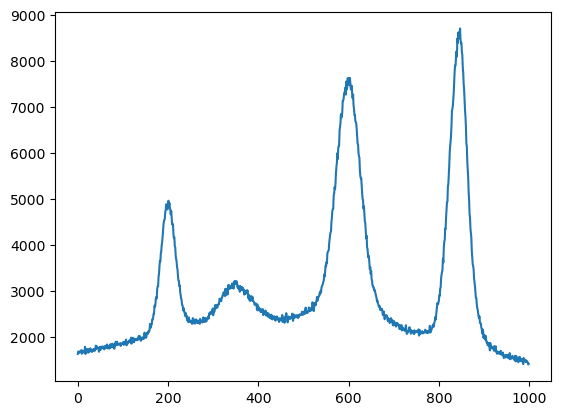

In [104]:
plt.plot(y)

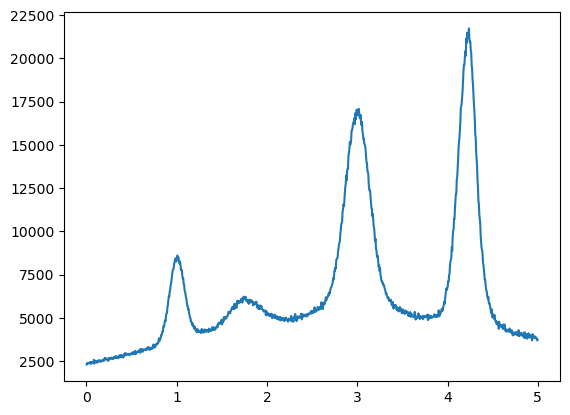

In [105]:
y=y*np.sqrt(x+2)
plt.plot(x,y)